In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.eval import calculate_rouge

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv("data/debatesum/test.csv")

scores = json.load(open("results/t5/checkpoint-1500_debatesum.json", "r"))
beam_score_ratios = scores.pop("beam_score_ratios")

In [3]:
metric = list[float]()
for pred, label in zip(scores["sentences"], df["target"]):
    rouge = calculate_rouge(predictions=[pred], references=[[label]])["rougeL"]
    metric.append(rouge)

In [4]:
df_score = pd.DataFrame.from_dict(scores)
df_score["beam_score_ratio"] = beam_score_ratios["99"]
df_score["rougeL"] = metric

In [6]:
df_score.drop(["sentences", "dropout_sentences"], axis=1).corr(method="spearman")[
    "rougeL"
]

length_normalized_log_probs     -0.050344
importance_weighted_log_probs    0.061065
mean_token_entropy               0.043870
dropout_bleu_variance            0.096406
dropout_meteor_score             0.126813
dropout_entropy                 -0.019063
dropout_disagreement             0.012411
beam_score_ratio                 0.284487
rougeL                           1.000000
Name: rougeL, dtype: float64

Text(0.5, 1.0, 'DebateSumm')

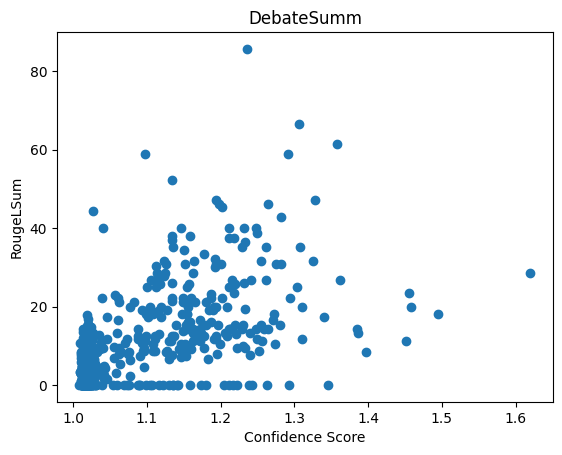

In [8]:
plt.scatter(y=df_score["rougeL"], x=df_score["beam_score_ratio"])
plt.xlabel("Confidence Score")
plt.ylabel("RougeLSum")
plt.title("DebateSumm")

/home/mila/f/floresl/miniconda3/envs/al/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mila/f/floresl/miniconda3/envs/al/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'DebateSumm')

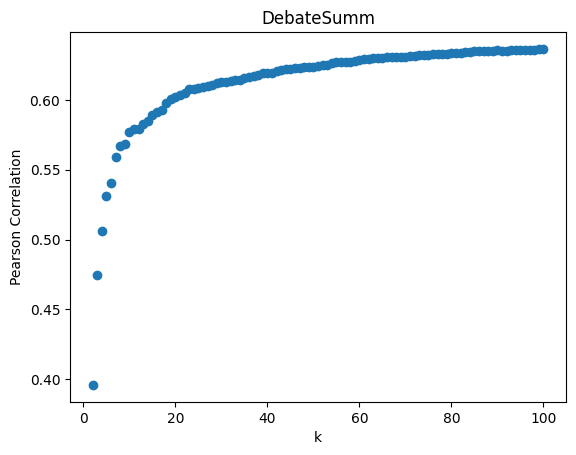

In [10]:
correlations = [
    np.corrcoef(df_score["rougeL"], beam_score_ratios[str(k)])[0, 1] for k in range(100)
]
plt.scatter(x=list(range(1, 101)), y=correlations)
plt.xlabel("k")
plt.ylabel("Pearson Correlation")
plt.title("DebateSumm")